# Auswertung

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fitz  # PyMuPDF
from wordcloud import WordCloud
from collections import Counter

In [2]:
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json 
import os
import textwrap
import pingouin as pg

## Stichprobenerhebung

### Datenerhebung


In [3]:
# Function to parse the .txt file and extract required fields
def parse_txt_file(file_path):
    data = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Split each line into key and value
            if ':' in line:
                key, value = line.strip().split(':', 1)
                data[key.strip()] = value.strip()
                if "Gruppe" in line:
                    break
    return data

# Function to go through all directories and extract data from .txt files
def extract_data_from_folders(base_directory):
    extracted_data = []
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.txt') and file.split("_")[0] == "Versuch" and len(file.split("_")) == 2:
                file_path = os.path.join(root, file)
                data = parse_txt_file(file_path)
                extracted_data.append(data)
    return extracted_data


base_directory = "..\..\Interviewdaten"
extracted_data = extract_data_from_folders(base_directory)


stichprobe_df = pd.DataFrame(extracted_data)
stichprobe_df

,Geschlecht,Alter,Erfahrung,Gruppe
0,Männlich,24,<1,Chatbot
1,Weiblich,26,1-5,Mensch
2,Männlich,25,1-5,Chatbot
3,Männlich,31,1-5,Mensch
4,Männlich,25,<1,Chatbot
5,Männlich,22,<1,Mensch
6,Männlich,23,<1,Chatbot
7,Männlich,26,1-5,Mensch
8,Männlich,25,1-5,Chatbot
9,Männlich,28,<1,Mensch


### Visualisierung

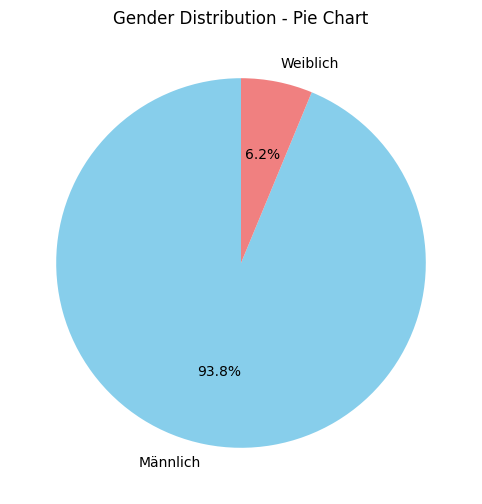

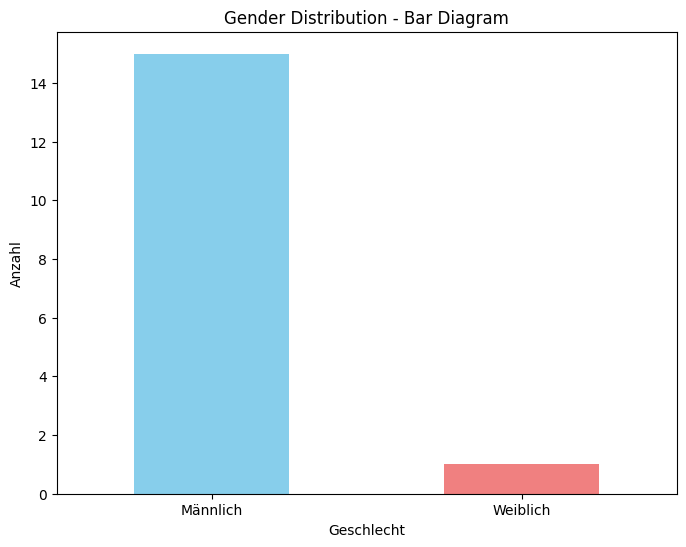

In [4]:
import matplotlib.pyplot as plt

# Count occurrences of each gender
experience_counts = stichprobe_df['Geschlecht'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    experience_counts, 
    labels=experience_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'lightcoral']
)
plt.title('Gender Distribution - Pie Chart')
plt.show()

# Plot a bar diagram
plt.figure(figsize=(8, 6))
experience_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Gender Distribution - Bar Diagram')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


In [5]:
stichprobe_df['Alter'] = pd.to_numeric(stichprobe_df['Alter'], errors='coerce')
stichprobe_df["Alter"].mean()

27.4375

In [6]:
stichprobe_df["Alter"].std(ddof=1)

7.728464703074386

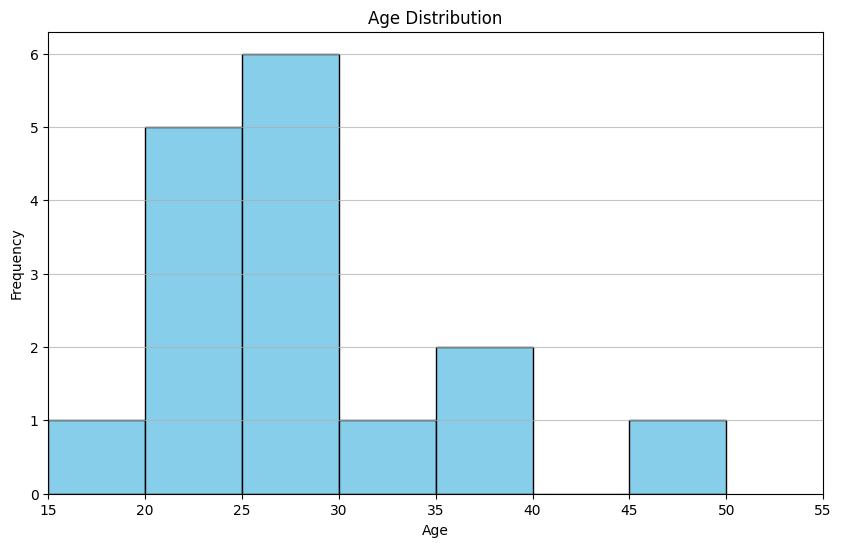

In [7]:
# Ensure 'Alter' column is numeric
stichprobe_df['Alter'] = pd.to_numeric(stichprobe_df['Alter'])

min_stichprobe = int(min(stichprobe_df['Alter']) / 5) * 5
max_stichprobe = (int(max(stichprobe_df['Alter']) / 5) + 1) * 5

# Plot the histogram
bin_edges = np.arange(min_stichprobe, max_stichprobe, 5)
plt.figure(figsize=(10, 6))
plt.hist(stichprobe_df['Alter'], bins=bin_edges, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.xlim(min_stichprobe, max_stichprobe)
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

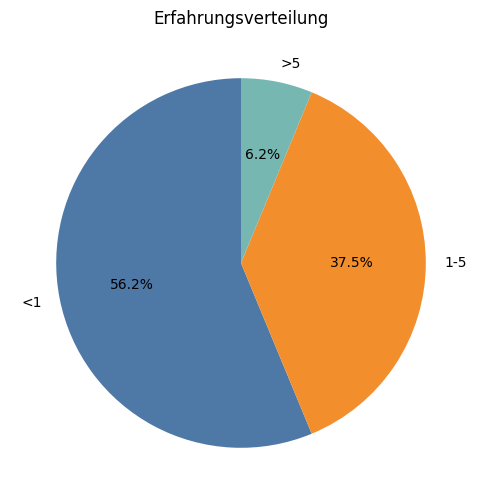

In [8]:
# Count occurrences 
experience_counts = stichprobe_df['Erfahrung'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    experience_counts, 
    labels=experience_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#4E79A7', '#F28E2C', '#76B7B2']
)
plt.title('Erfahrungsverteilung')
plt.show()

## Inferenzstatistik

### Fragebogen


#### Datenerhebung


In [9]:
scoring = {
    "stimme absolut zu": 7,
    "stimme sehr zu": 6,
    "stimme eher zu": 5,
    "stimme teilweise zu/teilweise nicht": 4,
    "stimme eher nicht zu": 3,
    "stimme überhaupt nicht zu": 2,
    "stimme absolut nicht zu": 1
}

In [10]:
def fetch_survey(pdf_document:str, chatbot:bool, index: int):
    doc = fitz.open(pdf_document)

    # Extract text from each page
    page = doc[0]
    text = page.get_text().lower()
    text = text.split("bitte jede frage beantworten:")[1]

    survey_nominal = {}
    survey_scalar = {}
    line_split = text.split("stimme")
    for i,line in enumerate(line_split):
        if i != 0:
            question = "\n".join(line_split[i-1].split("\n")[1:]).replace("\n"," ")
            answer = "stimme" + line_split[i].split("\n")[0]

            if question.startswith("ich hatte das gefühl ich konnte meine meinung mitteilen ohne verurteilt zu werden"):
                question = question.replace("ich hatte das gefühl", "")
            if "ich wurde vom interviewer zu meinungen/ aussagen gedrängt" in question:
                survey_scalar["ich wurde NICHT vom interviewer zu meinungen/ aussagen gedrängt (umgekehrt)"] = 8 - scoring[answer]
                survey_nominal["ich wurde NICHT vom interviewer zu meinungen/ aussagen gedrängt (umgekehrt)"] = answer
            elif "ich stand unter zeitdruck" in question:
                survey_scalar["ich stand NICHT unter zeitdruck (umgekehrt)"] = 8 - scoring[answer]
                survey_nominal["ich stand NICHT unter zeitdruck (umgekehrt)"] = answer
            else:
                survey_scalar[question] = scoring[answer]
                survey_nominal[question] = answer

    sum_of_all = 0
    for key in survey_scalar:
        sum_of_all += survey_scalar[key]
    survey_scalar["durchschnitt"] = sum_of_all/len(survey_scalar.keys())
    
    # append group category
    survey_scalar["chatbot_first"] = chatbot
    survey_nominal["chatbot_first"] = chatbot

    survey_scalar["index"] = index
    survey_nominal["index"] = index

            
        


    umfragen_nominal_df = pd.DataFrame([survey_nominal])


    umfragen_scalar_df = pd.DataFrame([survey_scalar])
    return umfragen_scalar_df, umfragen_nominal_df

In [11]:
# Function to go through all directories and extract data from .pdf surveys
def extract_survey_from_folders(base_directory:str, ending:str):
    extracted_surveys = []
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(ending) and file.startswith("Versuch"):
                file_path = os.path.join(root, file)
                data = fetch_survey(file_path, chatbot = int(file.split("_")[1]) % 2 == 0, index = int(file.split("_")[1]))
                extracted_surveys.append(data)

    return extracted_surveys

base_directory = "..\..\Interviewdaten"
extracted_human_surveys = extract_survey_from_folders(base_directory, "Mensch.pdf")
extracted_chatbot_surveys = extract_survey_from_folders(base_directory, "Chatbot.pdf")

scalar_human_survey = pd.DataFrame()
nominal_human_survey = pd.DataFrame()
scalar_chatbot_survey = pd.DataFrame()
nominal_chatbot_survey = pd.DataFrame()
for scalar_survey, nominal_survey in extracted_human_surveys:
    scalar_human_survey = pd.concat([scalar_human_survey, scalar_survey], ignore_index = True)
    nominal_human_survey = pd.concat([nominal_human_survey, nominal_survey], ignore_index = True)

for scalar_survey, nominal_survey in extracted_chatbot_surveys:
    scalar_chatbot_survey = pd.concat([scalar_chatbot_survey, scalar_survey], ignore_index = True)
    nominal_chatbot_survey = pd.concat([nominal_chatbot_survey, nominal_survey], ignore_index = True)

scalar_human_survey = scalar_human_survey.set_index("index", drop=True).sort_values("index")
nominal_human_survey = nominal_human_survey.set_index("index", drop=True).sort_values("index")
scalar_chatbot_survey = scalar_chatbot_survey.set_index("index", drop=True).sort_values("index")
nominal_chatbot_survey = nominal_chatbot_survey.set_index("index", drop=True).sort_values("index")

# Define the correct column names
correct_column_names = [
    "Das Interview war angenehm",
    "Ich habe das Interview als offen wahrgenommen",
    "Ich stand NICHT unter Zeitdruck (umgekehrt)",
    "Ich würde in Zukunft wieder an einem Interview dieser Art teilnehmen",
    "Ich hatte das Gefühl, dass meine Rückmeldungen wichtig sind",
    "Der Interviewer wirkte empathisch",
    "Ich wurde vom Interviewer verstanden",
    "Ich wurde vom Interviewer NICHT zu Meinungen/ Aussagen gedrängt (umgekehrt)",
    "Ich konnte alles erwähnen, was ich sagen wollte",
    "Das Interview wirkte professionell",
    "Das Interview wurde gut geführt",
    "Meine Meinung wurde vom Interviewer ernst genommen",
    "Ich konnte meine Meinung mitteilen, ohne verurteilt zu werden",
    "Der Interviewer ist gut auf meine Antworten eingegangen",
    "Der Interviewer war freundlich/ einladend",
    "Ich vertraue dem Interviewer",
    "Durchschnitt",
    "chatbot_first"
]

# Update the column names for both DataFrames
scalar_human_survey.columns = correct_column_names
scalar_chatbot_survey.columns = correct_column_names

scalar_human_survey


,Das Interview war angenehm,Ich habe das Interview als offen wahrgenommen,Ich stand NICHT unter Zeitdruck (umgekehrt),Ich würde in Zukunft wieder an einem Interview dieser Art teilnehmen,"Ich hatte das Gefühl, dass meine Rückmeldungen wichtig sind",Der Interviewer wirkte empathisch,Ich wurde vom Interviewer verstanden,Ich wurde vom Interviewer NICHT zu Meinungen/ Aussagen gedrängt (umgekehrt),"Ich konnte alles erwähnen, was ich sagen wollte",Das Interview wirkte professionell,Das Interview wurde gut geführt,Meine Meinung wurde vom Interviewer ernst genommen,"Ich konnte meine Meinung mitteilen, ohne verurteilt zu werden",Der Interviewer ist gut auf meine Antworten eingegangen,Der Interviewer war freundlich/ einladend,Ich vertraue dem Interviewer,Durchschnitt,chatbot_first
index,,,,,,,,,,,,,,,,,,
2,7,7,6,7,6,7,7,6,7,7,6,6,6,7,7,7,6.6250,True
3,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7.0000,False
4,7,7,5,7,6,7,7,7,7,7,7,7,7,6,7,7,6.7500,True
5,7,7,7,4,7,7,7,6,7,7,7,7,7,7,7,6,6.6875,False
6,6,5,6,5,4,5,5,6,5,6,6,4,5,4,5,4,5.0625,True
7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7.0000,False
8,6,6,7,7,7,7,7,7,7,6,7,6,7,7,7,7,6.7500,True
9,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7.0000,False
10,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7.0000,True


In [12]:
scalar_chatbot_survey

,Das Interview war angenehm,Ich habe das Interview als offen wahrgenommen,Ich stand NICHT unter Zeitdruck (umgekehrt),Ich würde in Zukunft wieder an einem Interview dieser Art teilnehmen,"Ich hatte das Gefühl, dass meine Rückmeldungen wichtig sind",Der Interviewer wirkte empathisch,Ich wurde vom Interviewer verstanden,Ich wurde vom Interviewer NICHT zu Meinungen/ Aussagen gedrängt (umgekehrt),"Ich konnte alles erwähnen, was ich sagen wollte",Das Interview wirkte professionell,Das Interview wurde gut geführt,Meine Meinung wurde vom Interviewer ernst genommen,"Ich konnte meine Meinung mitteilen, ohne verurteilt zu werden",Der Interviewer ist gut auf meine Antworten eingegangen,Der Interviewer war freundlich/ einladend,Ich vertraue dem Interviewer,Durchschnitt,chatbot_first
index,,,,,,,,,,,,,,,,,,
2,2,3,7,1,2,1,2,1,6,1,2,3,7,1,1,4,2.7500,True
3,7,7,7,7,7,4,7,7,7,7,3,7,7,7,7,4,6.3750,False
4,6,5,2,6,5,5,5,4,7,6,6,6,7,4,6,5,5.3125,True
5,3,3,3,1,3,1,3,1,2,4,2,3,2,2,1,2,2.2500,False
6,5,5,6,5,3,3,4,4,7,5,5,4,7,4,5,4,4.7500,True
7,5,7,7,5,7,5,4,1,7,7,7,7,7,6,7,7,6.0000,False
8,4,5,7,5,6,4,6,6,6,6,5,6,6,5,4,5,5.3750,True
9,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7.0000,False
10,5,4,7,1,5,3,3,7,7,2,2,6,7,5,6,2,4.5000,True


In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro

#https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests

# Sample Sizes
N = 16

# Degrees of freedom  
dof = N - 1

# niveau of significance
nos = 0.05

columns_to_plot = scalar_chatbot_survey.columns[:-1]

results = pd.DataFrame()

for i, col in enumerate(columns_to_plot):
    x = scalar_human_survey[col]
    y = scalar_chatbot_survey[col]
    x_y_diff = x-y

    # mean
    chatbot_mean = np.mean(y)
    human_mean = np.mean(x)
    mean = np.mean((x + y) / 2)

    # Standard Deviation  
    chatbot_std = np.std(y, ddof=1)
    human_std = np.std(x, ddof=1)
    std = np.std(x, ddof=1) 

    # t-value and p-value
    t_stat, p_val = stats.ttest_rel(x,y)   

    
    stat_chatbot, shapiro_p_value_chatbot = shapiro(x_y_diff)

    results[col] = {"mean":mean, "chatbot_mean": chatbot_mean, "human_mean": human_mean, "mean_diff": human_mean-chatbot_mean,"std":std,  "chatbot_std": chatbot_std, "human_std": human_std, "shapiro": shapiro_p_value_chatbot, "t_stat":t_stat, "p_val": p_val, "significant": p_val < nos}

results

,Das Interview war angenehm,Ich habe das Interview als offen wahrgenommen,Ich stand NICHT unter Zeitdruck (umgekehrt),Ich würde in Zukunft wieder an einem Interview dieser Art teilnehmen,"Ich hatte das Gefühl, dass meine Rückmeldungen wichtig sind",Der Interviewer wirkte empathisch,Ich wurde vom Interviewer verstanden,Ich wurde vom Interviewer NICHT zu Meinungen/ Aussagen gedrängt (umgekehrt),"Ich konnte alles erwähnen, was ich sagen wollte",Das Interview wirkte professionell,Das Interview wurde gut geführt,Meine Meinung wurde vom Interviewer ernst genommen,"Ich konnte meine Meinung mitteilen, ohne verurteilt zu werden",Der Interviewer ist gut auf meine Antworten eingegangen,Der Interviewer war freundlich/ einladend,Ich vertraue dem Interviewer,Durchschnitt
mean,5.71875,5.875,6.15625,5.53125,5.34375,5.09375,5.53125,5.34375,6.40625,5.5625,5.4375,5.8125,6.5,5.21875,5.78125,5.375,5.667969
chatbot_mean,4.6875,5.0625,5.625,4.5,4.4375,3.5,4.1875,4.375,6.0625,4.625,4.125,4.9375,6.3125,4.0,4.9375,4.1875,4.722656
human_mean,6.75,6.6875,6.6875,6.5625,6.25,6.6875,6.875,6.3125,6.75,6.5,6.75,6.6875,6.6875,6.4375,6.625,6.5625,6.613281
mean_diff,2.0625,1.625,1.0625,2.0625,1.8125,3.1875,2.6875,1.9375,0.6875,1.875,2.625,1.75,0.375,2.4375,1.6875,2.375,1.890625
std,0.447214,0.704154,0.60208,0.892095,1.0,0.60208,0.5,1.302242,0.57735,0.632456,0.447214,0.7932,0.60208,0.963933,0.885061,0.892095,0.484778
chatbot_std,1.662077,1.481834,1.821172,2.309401,1.896268,1.788854,1.796988,2.362908,1.388944,2.093641,1.927866,1.913766,1.352467,2.097618,2.048373,1.600781,1.373857
human_std,0.447214,0.704154,0.60208,0.892095,1.0,0.60208,0.5,1.302242,0.57735,0.632456,0.447214,0.7932,0.60208,0.963933,0.885061,0.892095,0.484778
shapiro,0.01395,0.015081,0.00179,0.014101,0.022169,0.180415,0.459114,0.153684,0.002654,0.301987,0.126255,0.013954,0.002287,0.042083,0.008773,0.168896,0.241514
t_stat,4.663797,4.210377,2.57261,4.027586,3.953729,6.953109,5.80516,3.113521,1.740704,3.337456,5.351296,3.590924,0.945537,4.650333,2.970802,5.988399,5.520952
p_val,0.000306,0.000757,0.021224,0.001096,0.001274,0.000005,0.000035,0.007118,0.102202,0.0045,0.000081,0.002675,0.359368,0.000314,0.009522,0.000025,0.000059


In [14]:
def fetch_qualitative_response(pdf_document:str):
    doc = fitz.open(pdf_document)

    # Extract text from each page
    page = doc[0]
    text = page.get_text().lower()
    if len(doc) > 1:
        text += doc[1].get_text().lower()

    interview_qualitative_response = text.split("ich habe mich während dem interview")[1]
    interview_qualitative_response = interview_qualitative_response.split("gefühlt")[0].strip()

    interviewer_qualitative_response = text.split("der interviewer wirkte")[2]
    interviewer_qualitative_response = interviewer_qualitative_response.split(".")[0].strip()

    return (interview_qualitative_response, interviewer_qualitative_response)

# Function to go through all directories and extract data from .pdf surveys
def extract_survey_from_folders(base_directory:str, ending:str):
    extracted_surveys = []
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(ending) and file.startswith("Versuch"):
                file_path = os.path.join(root, file)
                data = fetch_qualitative_response(file_path)
                extracted_surveys.append(data)
    return extracted_surveys

base_directory = "..\..\Interviewdaten"
extracted_human_surveys = extract_survey_from_folders(base_directory, "Mensch.pdf")
extracted_chatbot_surveys = extract_survey_from_folders(base_directory, "Chatbot.pdf")

    
human_interviewer_qual = []
human_interview_qual = []
chatbot_interviewer_qual = []
chatbot_interview_qual = []
for extraced_qualitative_data in extracted_human_surveys:
    human_interview_qual.append(extraced_qualitative_data[0])
    human_interviewer_qual.append(extraced_qualitative_data[1])

for extraced_qualitative_data in extracted_chatbot_surveys:
    chatbot_interview_qual.append(extraced_qualitative_data[0])
    chatbot_interviewer_qual.append(extraced_qualitative_data[1])

human_interview_qual

['wohl',
 'gut',
 'gehört',
 'gut',
 'sehr gut',
 'wohl',
 'verstanden positiv',
 'gut',
 'verstanden',
 'gut',
 'fröhlich',
 'gut',
 'ok',
 'sehr gut',
 'wohl',
 'super']

In [15]:
chatbot_interview_qual

['gut',
 'gut',
 'genervt',
 'unverstanden',
 'wohl',
 'sicher',
 'neutral',
 'entspannt',
 'schlecht',
 'gut',
 'leicht gestresst',
 'unwohl',
 'ok',
 'wiederholt',
 'wohl',
 'super']

In [16]:
human_interviewer_qual

['so, dass er ahnung von dem thema hatte',
 'durchdacht',
 'freundlich',
 'angenehm',
 'sympatisch',
 'ruhig/professionell',
 'freundlich entspannt',
 'nett und empatisch',
 'aufmerksam, da er auch vorhandene antworten eingehen konnte',
 'sehr professionell',
 'nett',
 'professionell',
 'zielgerichtet',
 'entspannt und verständnisvoll',
 'vertrauenswürdig',
 'sympathisch']

In [17]:
chatbot_interviewer_qual

['als ob er fragen zu einem thema stellt, das er nicht gut kennt',
 'für eine ki relativ menschlich',
 'abgelesen',
 'wie ein chatbot',
 'sympatisch',
 'langsam',
 'etwas aufdringlich',
 'manchmal verwirrt',
 'komisch',
 'gut aber nicht professionell, die themen wurden teilweise durcheinander geworfen',
 'freundlich',
 'sarkastisch',
 'pragmatisch',
 'zu technisch/trocken',
 'interessiert',
 'professionell']

#### Visualisierung


In [18]:
# Function to insert a line break in a title after a certain number of characters
def wrap_title(title, max_len=30):
    # Split the title if it exceeds the max_len
    if len(title) > max_len:
        for i in range(int(len(title)/2)):
            current_index = int((len(title)/2) - i)
            if title[current_index] == " ":
                return title[:current_index] + "\n" + title[current_index:]
        
                
    return title

c:\Users\MRiesle\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\MRiesle\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\MRiesle\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\MRiesle\AppData\Local\Programs\Python\P

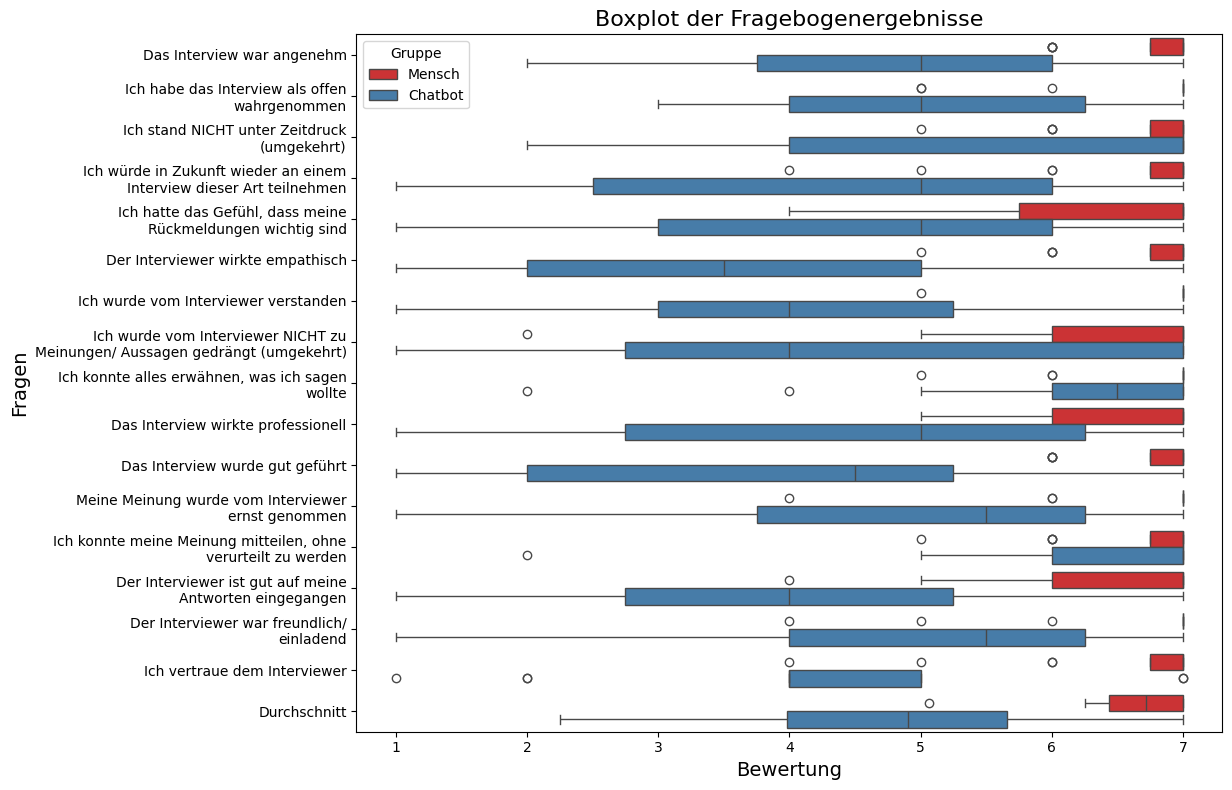

In [19]:
# Combine the data into a single DataFrame
combined_df = pd.concat([
    scalar_human_survey.iloc[:, :-1].assign(Gruppe='Mensch'),
    scalar_chatbot_survey.iloc[:, :-1].assign(Gruppe='Chatbot')
])

# Melt the DataFrame to long format for Seaborn
melted_df = combined_df.melt(id_vars=['Gruppe'], var_name='Question', value_name='Rating')

# Plot the boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(x='Rating', y='Question', data=melted_df, hue='Gruppe', orient='h', palette='Set1', width=0.8)

# Enhance the plot with labels and a title
plt.title('Boxplot der Fragebogenergebnisse', fontsize=16)
plt.xlabel('Bewertung', fontsize=14)
plt.ylabel('Fragen', fontsize=14)
plt.tight_layout()

wrapped_labels = [textwrap.fill(label, 40) for label in melted_df['Question'].unique()]
plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels)

# Show the plot
plt.show()

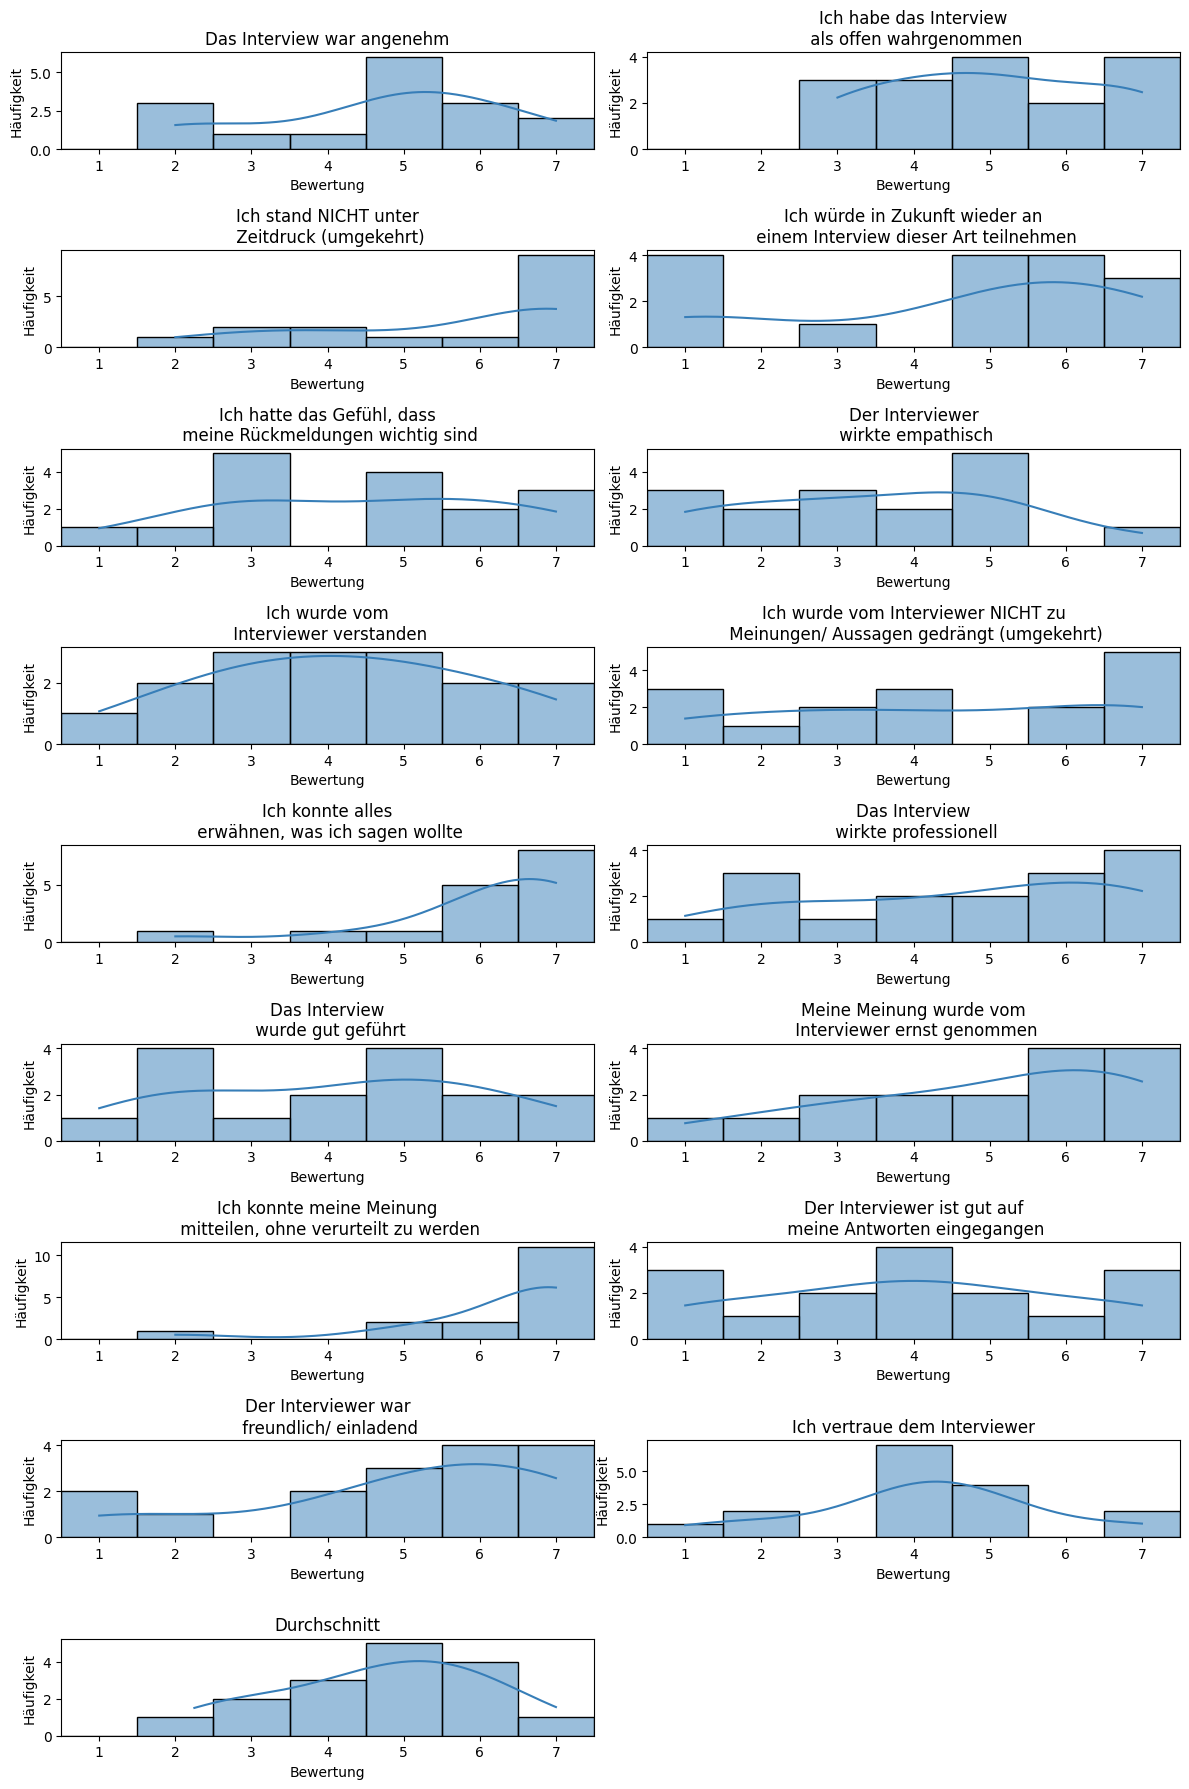

In [20]:
# Set up the matplotlib figure with a new width-to-height ratio
plt.figure(figsize=(12, 18))

# Get the second color from the Set1 palette
set1_color = sns.color_palette("Set1")[1]

# Plot a distribution for each column
bin_edges = np.arange(0.5, 8.5, 1)  # so the bins are centered around the label 
for idx, column in enumerate(scalar_chatbot_survey.iloc[:, :-1].columns):
    plt.subplot(9, 2, idx + 1)  # Create a grid of 9x2 for subplots
    sns.histplot(scalar_chatbot_survey[column], kde=True, bins=bin_edges, color=set1_color)
    
    # Wrap the title if needed and set it
    wrapped_title = wrap_title(column)
    plt.title(wrapped_title)
    
    plt.xlim(0.5, 7.5)
    plt.xlabel('Bewertung')
    plt.ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

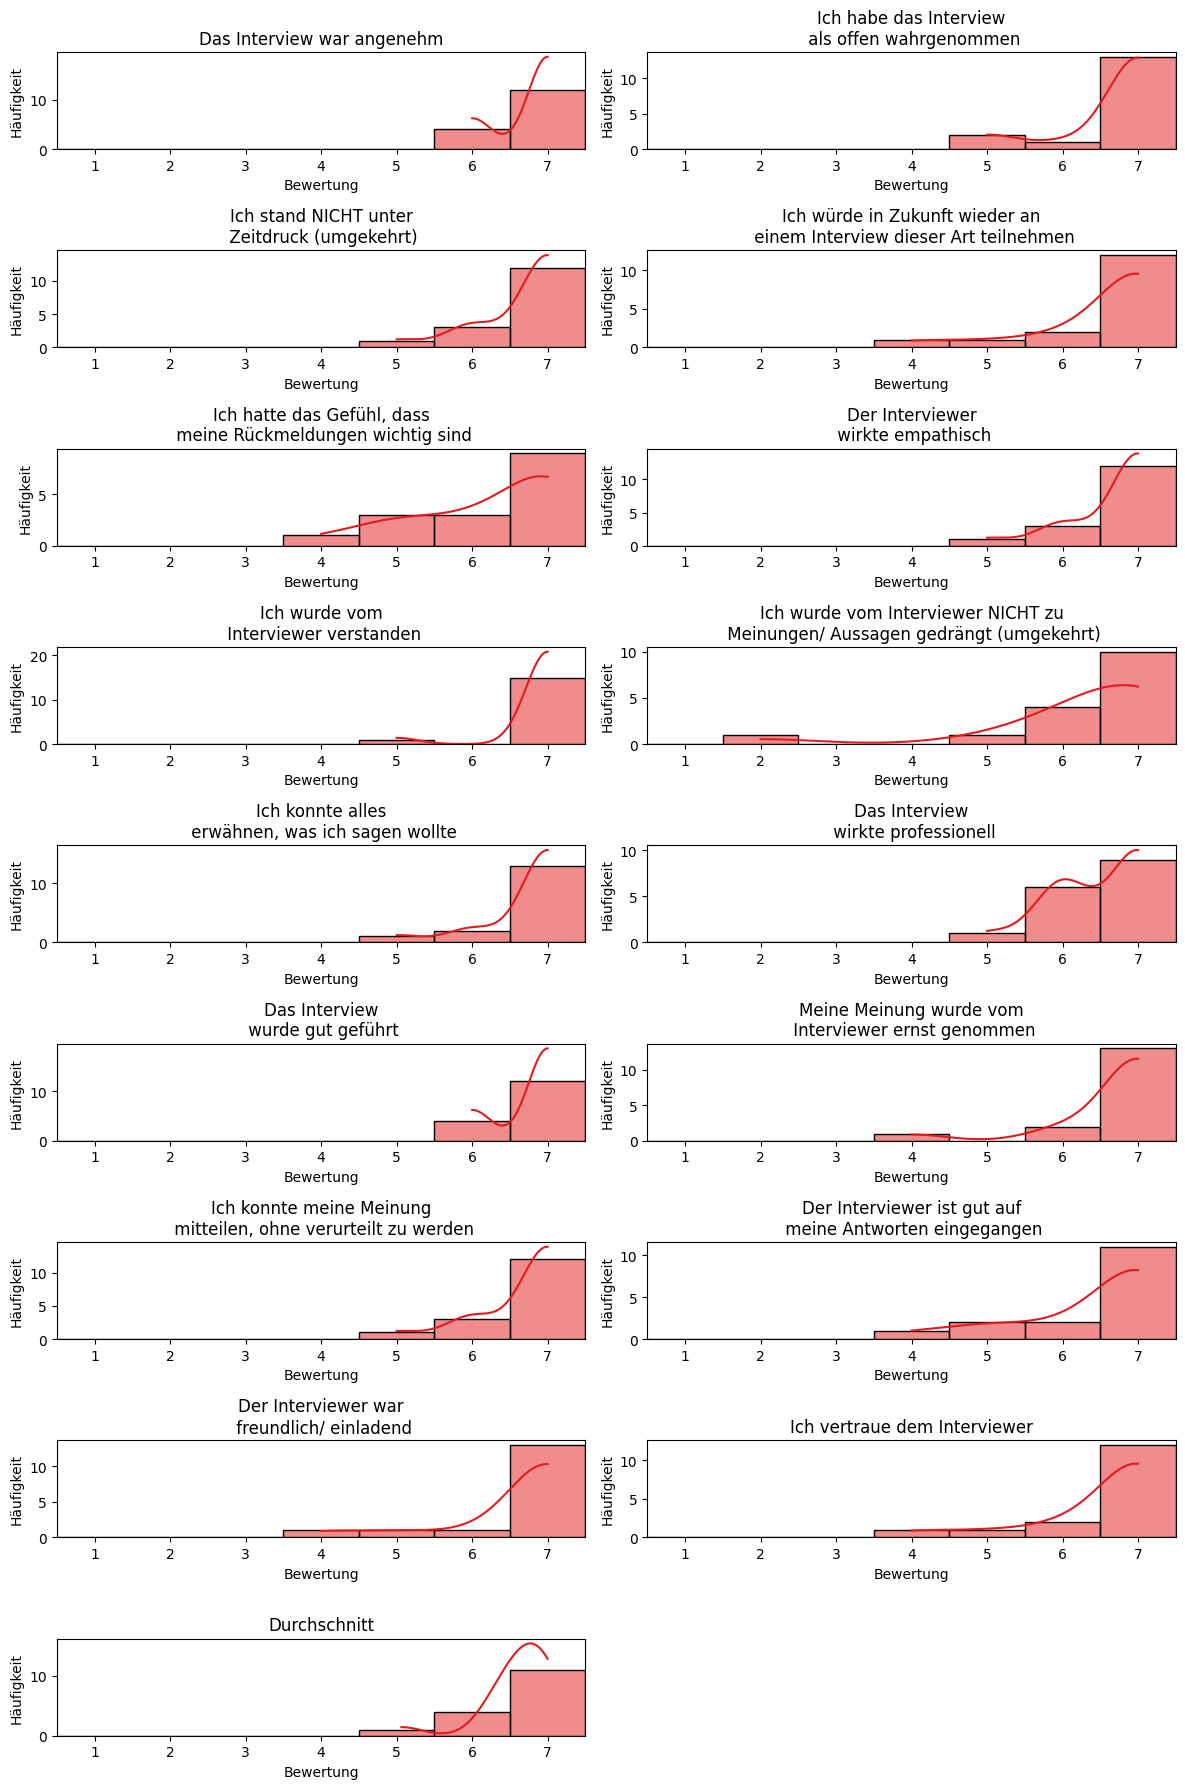

In [21]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 18))

# Get the first color from the Set1 palette
set1_color = sns.color_palette("Set1")[0]

# Plot a distribution for each column
bin_edges = np.arange(0.5, 8.5, 1)  # so the bins are centered around the label 
for idx, column in enumerate(scalar_human_survey.iloc[:, :-1].columns):
    plt.subplot(9, 2, idx + 1)  # Create a grid of 9x2 for subplots
    sns.histplot(scalar_human_survey[column], kde=True, bins=bin_edges, color=set1_color)
    
    # Wrap the title if needed and set it
    wrapped_title = wrap_title(column)
    plt.title(wrapped_title)
    
    plt.xlim(0.5,7.5)
    plt.xlabel('Bewertung')
    plt.ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

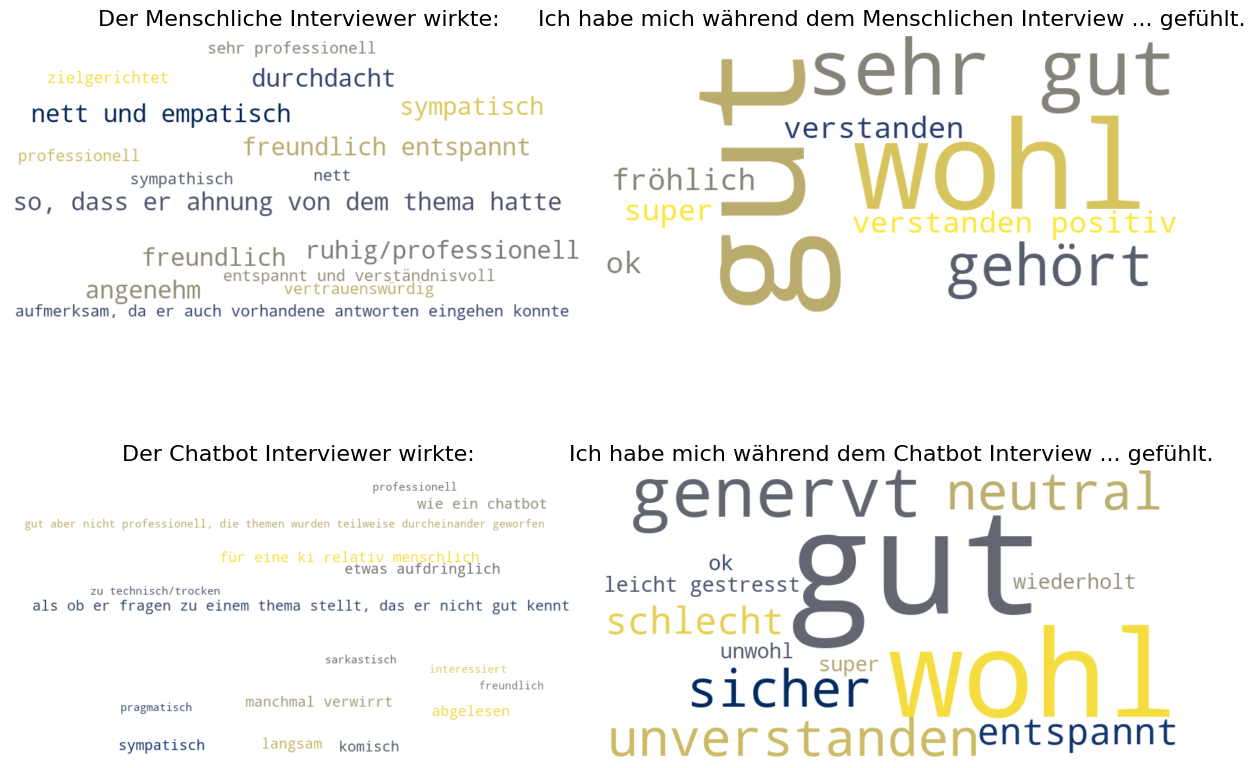

In [22]:
# Create a list of all word lists
word_lists = [human_interviewer_qual,human_interview_qual,chatbot_interviewer_qual,chatbot_interview_qual]
titles =  ["Der Menschliche Interviewer wirkte:","Ich habe mich während dem Menschlichen Interview ... gefühlt.","Der Chatbot Interviewer wirkte:","Ich habe mich während dem Chatbot Interview ... gefühlt."]

# Set up a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through the word lists and create a word cloud for each
for i, word_list in enumerate(word_lists):
    # Count the occurrences of each word
    word_freq = Counter(word_list)
    
    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='cividis',  
        min_font_size=15,
        relative_scaling=0.5
    ).generate_from_frequencies(word_freq)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(titles[i], fontsize=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Restliche Metriken


#### Datenerhebung

In [23]:
# every interview folder has a JSON with the metrics of the interview
def fetch_metric_json(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError as e:
        raise FileNotFoundError(f"The file at {file_path} was not found.") from e
    except json.JSONDecodeError as e:
        raise ValueError(f"The file at {file_path} is not a valid JSON.") from e
    
def clean_up_metrics(data: dict, index: int, type:str):
    data["Nutzer"] = len(data["Erkenntnisse"]["Nutzer"])
    data["Ziele"] = len(data["Erkenntnisse"]["Ziele"])
    data["Aufgaben"] = len(data["Erkenntnisse"]["Aufgaben"])
    data["Umgebung"] = len(data["Erkenntnisse"]["Umgebung"])
    data["Ressourcen"] = len(data["Erkenntnisse"]["Ressourcen"])

    data["leading_biased_fragen"] = len(data["leading_biased_fragen"])
    data["geschlossene_fragen"] = len(data["geschlossene_fragen"])

    data["Erkenntnisse"] = data["Nutzer"] + data["Ziele"] + data["Aufgaben"] + data["Umgebung"] + data["Ressourcen"]

    data["leading_biased_fragen_pro_frage"] = data["leading_biased_fragen"] / data["fragen_gesamt"]
    data["geschlossene_fragen_pro_frage"] = data["geschlossene_fragen"] / data["fragen_gesamt"]
    data["klarstellungsanfragen_pro_frage"] = data["klarstellungsanfragen"] / data["fragen_gesamt"]

    data["informativität_pro_wort"] = data["informativität"] / data["Woerter_gesamt"]
    data["Erkenntnisse_pro_wort"] = data["Erkenntnisse"] / data["Woerter_gesamt"]

    if type == "human":
        data["fragebogen_schnitt"] = scalar_human_survey.iloc[index-2][ "Durchschnitt"]
        data["chatbot_first"] = scalar_human_survey.iloc[index-2][ "chatbot_first"]
    elif type == "chatbot":
        data["fragebogen_schnitt"] = scalar_chatbot_survey.iloc[index-2][ "Durchschnitt"]
        data["chatbot_first"] = scalar_chatbot_survey.iloc[index-2][ "chatbot_first"]
    else:
        raise ValueError(f"type cannot be {type}")

    data["index"] = index


    return data

# Function to go through all directories and extract data 
def extract_metrics_from_dirs(base_directory:str, start:str , ending:str):
    extracted_metrics = []
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(ending) and file.startswith(start):
                file_path = os.path.join(root, file)
                data = fetch_metric_json(file_path)
                data = clean_up_metrics(data, int(root.split("_")[-1]), start.split("_")[1])
                extracted_metrics.append(data)

    return extracted_metrics

base_directory = "..\..\Interviewdaten"
extracted_human_metrics = extract_metrics_from_dirs(base_directory, "metrics_human_",".json")
extracted_chatbot_metrics = extract_metrics_from_dirs(base_directory, "metrics_chatbot_",".json")

extracted_human_metrics_with_group_df = pd.DataFrame(extracted_human_metrics).set_index("index", drop=True).sort_values("index")
extracted_chatbot_metrics_with_group_df = pd.DataFrame(extracted_chatbot_metrics).set_index("index", drop=True).sort_values("index")

extracted_human_metric_df = extracted_human_metrics_with_group_df.drop(columns=['chatbot_first'])
extracted_chatbot_metric_df = extracted_chatbot_metrics_with_group_df.drop(columns=['chatbot_first'])

In [24]:
extracted_chatbot_metric_df

,Erkenntnisse,Woerter_gesamt,informativität,fragen_gesamt,klarstellungsanfragen,leading_biased_fragen,geschlossene_fragen,interview_laenge,Nutzer,Ziele,Aufgaben,Umgebung,Ressourcen,leading_biased_fragen_pro_frage,geschlossene_fragen_pro_frage,klarstellungsanfragen_pro_frage,informativität_pro_wort,Erkenntnisse_pro_wort,fragebogen_schnitt
index,,,,,,,,,,,,,,,,,,,
2,27,614,111.522300,16,0,1,1,1247,6,2,7,9,3,0.062500,0.062500,0.000000,0.181632,0.043974,2.7500
3,23,313,75.683077,20,0,3,2,1206,5,2,5,6,5,0.150000,0.100000,0.000000,0.241799,0.073482,6.3750
4,9,332,80.734636,12,0,0,1,1358,3,1,5,0,0,0.000000,0.083333,0.000000,0.243177,0.027108,5.3125
5,18,176,48.809269,23,0,1,3,1208,5,2,2,5,4,0.043478,0.130435,0.000000,0.277325,0.102273,2.2500
6,10,430,88.147869,11,0,0,1,1237,4,2,4,0,0,0.000000,0.090909,0.000000,0.204995,0.023256,4.7500
7,23,486,112.134140,18,0,2,3,1253,4,3,1,10,5,0.111111,0.166667,0.000000,0.230729,0.047325,6.0000
8,10,249,50.279781,8,0,0,1,1336,3,1,6,0,0,0.000000,0.125000,0.000000,0.201927,0.040161,5.3750
9,9,478,86.274269,9,0,0,1,1359,3,1,5,0,0,0.000000,0.111111,0.000000,0.180490,0.018828,7.0000
10,16,217,47.976841,13,0,2,1,1233,4,1,0,7,4,0.153846,0.076923,0.000000,0.221091,0.073733,4.5000


In [25]:
extracted_human_metric_df

,Erkenntnisse,Woerter_gesamt,informativität,fragen_gesamt,klarstellungsanfragen,leading_biased_fragen,geschlossene_fragen,interview_laenge,Nutzer,Ziele,Aufgaben,Umgebung,Ressourcen,leading_biased_fragen_pro_frage,geschlossene_fragen_pro_frage,klarstellungsanfragen_pro_frage,informativität_pro_wort,Erkenntnisse_pro_wort,fragebogen_schnitt
index,,,,,,,,,,,,,,,,,,,
2,32,1816,359.324607,36,2,4,3,1267,7,2,5,10,8,0.111111,0.083333,0.055556,0.197866,0.017621,6.6250
3,23,851,181.340133,39,0,8,7,935,5,2,6,4,6,0.205128,0.179487,0.000000,0.213091,0.027027,7.0000
4,29,2010,357.260749,35,0,3,9,1163,5,1,6,9,8,0.085714,0.257143,0.000000,0.177742,0.014428,6.7500
5,24,1522,269.434179,30,1,8,6,1237,3,3,3,8,7,0.266667,0.200000,0.033333,0.177026,0.015769,6.6875
6,17,913,161.701788,29,2,8,4,806,4,2,3,5,3,0.275862,0.137931,0.068966,0.177110,0.018620,5.0625
7,24,2777,526.469118,32,1,4,2,1357,4,2,3,8,7,0.125000,0.062500,0.031250,0.189582,0.008642,7.0000
8,25,824,161.508450,36,0,7,8,712,2,1,7,9,6,0.194444,0.222222,0.000000,0.196005,0.030340,6.7500
9,26,1233,227.613262,28,1,5,6,885,4,1,4,9,8,0.178571,0.214286,0.035714,0.184601,0.021087,7.0000
10,27,1030,169.297738,33,1,7,9,828,5,1,5,9,7,0.212121,0.272727,0.030303,0.164367,0.026214,7.0000


#### Visualisierungen / Berechnungen


##### Allgemein

In [26]:
extracted_human_metric_df.mean()

Erkenntnisse                         25.187500
Woerter_gesamt                     1333.375000
informativität                      248.204524
fragen_gesamt                        32.875000
klarstellungsanfragen                 0.937500
leading_biased_fragen                 6.625000
geschlossene_fragen                   5.875000
interview_laenge                    952.500000
Nutzer                                4.250000
Ziele                                 1.687500
Aufgaben                              4.875000
Umgebung                              7.625000
Ressourcen                            6.750000
leading_biased_fragen_pro_frage       0.203391
geschlossene_fragen_pro_frage         0.178894
klarstellungsanfragen_pro_frage       0.030156
informativität_pro_wort               0.191215
Erkenntnisse_pro_wort                 0.023359
fragebogen_schnitt                    6.613281
dtype: float64

In [27]:
extracted_chatbot_metric_df.mean()

Erkenntnisse                         17.250000
Woerter_gesamt                      358.625000
informativität                       78.163286
fragen_gesamt                        18.062500
klarstellungsanfragen                 0.250000
leading_biased_fragen                 1.250000
geschlossene_fragen                   1.875000
interview_laenge                   1252.875000
Nutzer                                4.187500
Ziele                                 1.500000
Aufgaben                              4.312500
Umgebung                              4.437500
Ressourcen                            2.812500
leading_biased_fragen_pro_frage       0.065926
geschlossene_fragen_pro_frage         0.103368
klarstellungsanfragen_pro_frage       0.009762
informativität_pro_wort               0.225748
Erkenntnisse_pro_wort                 0.054589
fragebogen_schnitt                    4.722656
dtype: float64

In [28]:
extracted_human_metric_df.mean()- extracted_chatbot_metric_df.mean()

Erkenntnisse                         7.937500
Woerter_gesamt                     974.750000
informativität                     170.041238
fragen_gesamt                       14.812500
klarstellungsanfragen                0.687500
leading_biased_fragen                5.375000
geschlossene_fragen                  4.000000
interview_laenge                  -300.375000
Nutzer                               0.062500
Ziele                                0.187500
Aufgaben                             0.562500
Umgebung                             3.187500
Ressourcen                           3.937500
leading_biased_fragen_pro_frage      0.137465
geschlossene_fragen_pro_frage        0.075526
klarstellungsanfragen_pro_frage      0.020394
informativität_pro_wort             -0.034532
Erkenntnisse_pro_wort               -0.031230
fragebogen_schnitt                   1.890625
dtype: float64

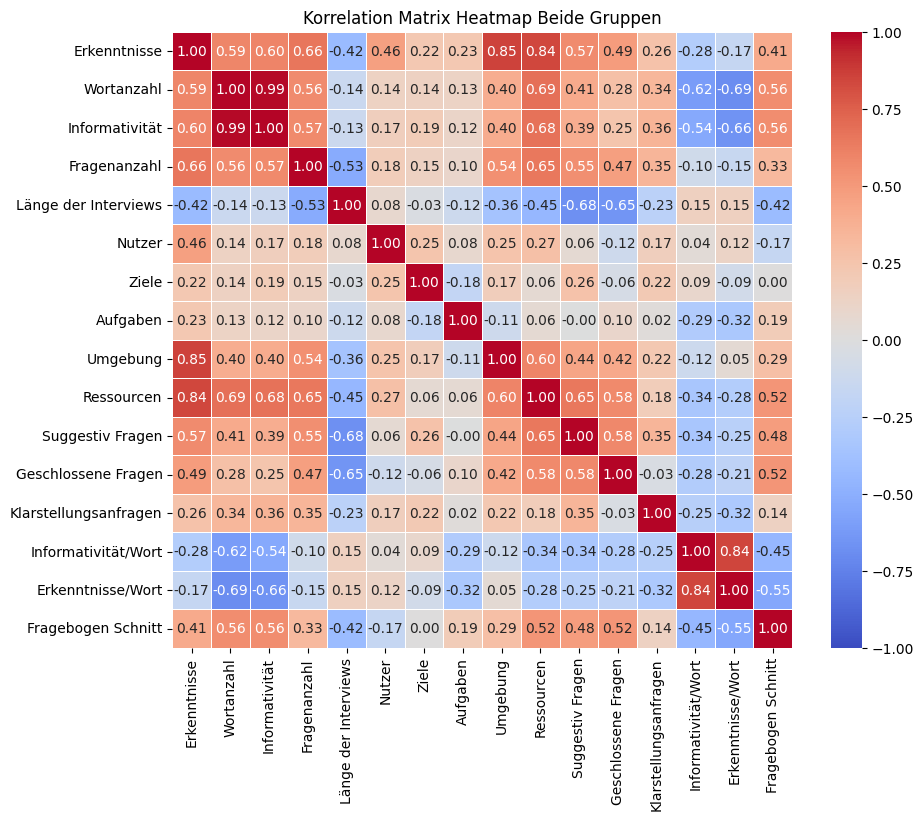

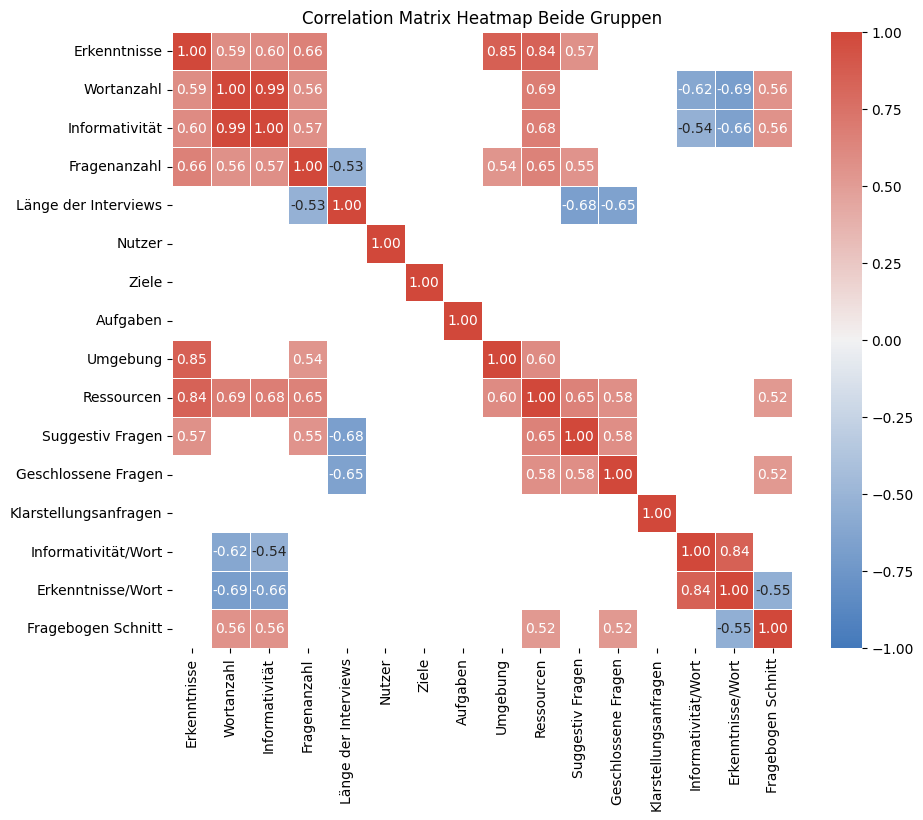

In [29]:
columns_to_plot = ["Erkenntnisse", "Woerter_gesamt","informativität","fragen_gesamt","interview_laenge","Nutzer", "Ziele", "Aufgaben", "Umgebung", "Ressourcen", "leading_biased_fragen_pro_frage", "geschlossene_fragen_pro_frage", "klarstellungsanfragen_pro_frage", "informativität_pro_wort", "Erkenntnisse_pro_wort", "fragebogen_schnitt"]

human_metric_only_relevant = extracted_human_metric_df[columns_to_plot]
chatbot_metric_only_relevant = extracted_chatbot_metric_df[columns_to_plot]

# Combine the metrics by stacking the dataframes
combined_metrics = pd.concat(
    [human_metric_only_relevant, chatbot_metric_only_relevant], axis=0
)
combined_metrics.columns = [
    "Erkenntnisse",
    "Wortanzahl",
    "Informativität",
    "Fragenanzahl",
    "Länge der Interviews",
    "Nutzer",
    "Ziele",
    "Aufgaben",
    "Umgebung",
    "Ressourcen",
    "Suggestiv Fragen",
    "Geschlossene Fragen",
    "Klarstellungsanfragen",
    "Informativität/Wort",
    "Erkenntnisse/Wort",
    "Fragebogen Schnitt",
]

correlation_matrix = combined_metrics.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)

# Add title and display the plot
plt.title("Korrelation Matrix Heatmap Beide Gruppen")
plt.show()

# Define a custom colormap that will make values between -0.5 and 0.5 grey
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Create a mask for values between -0.5 and 0.5
mask = np.abs(correlation_matrix) < 0.5

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap=cmap,
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    mask=mask,
)

# Add title and display the plot
plt.title("Correlation Matrix Heatmap Beide Gruppen")
plt.show()

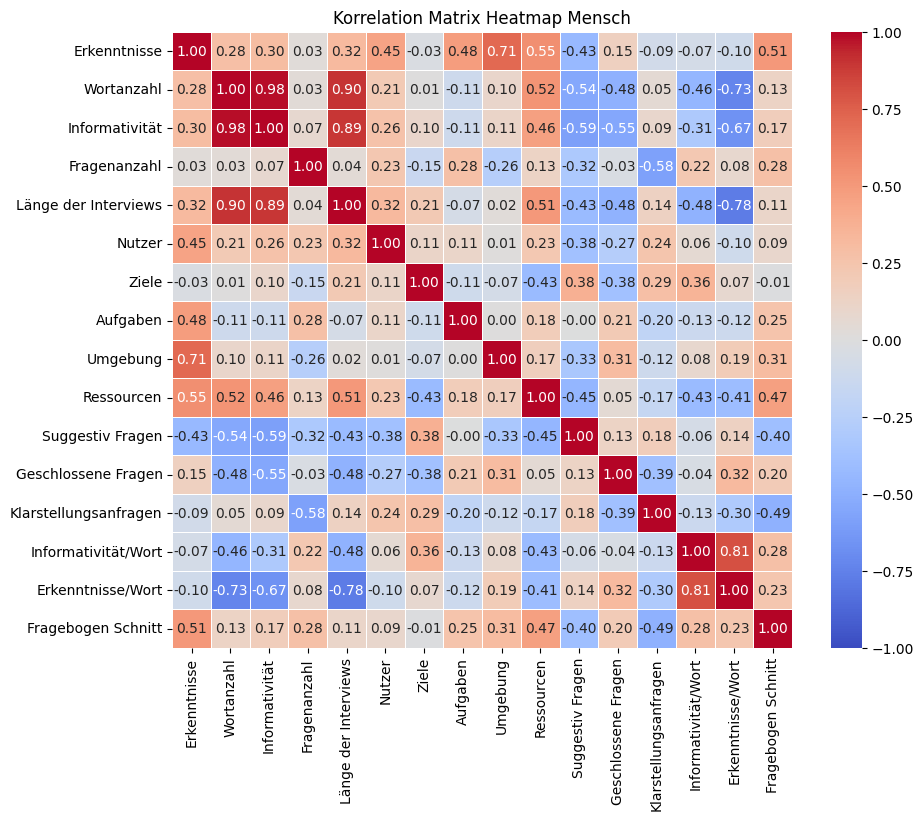

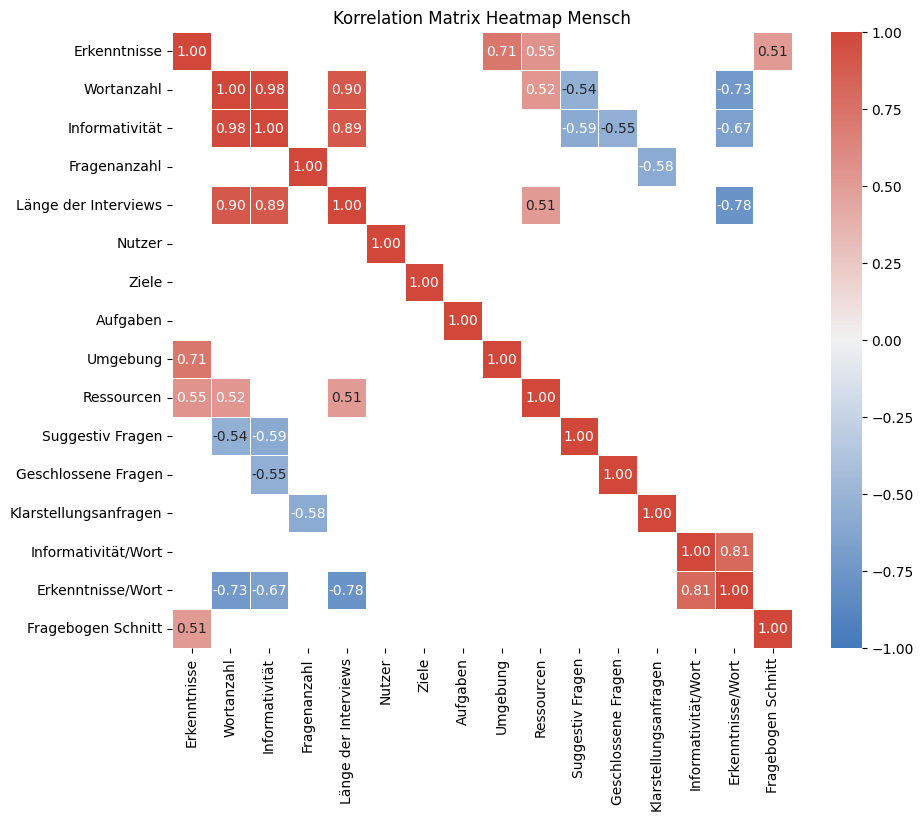

In [30]:
human_metric_only_relevant = extracted_human_metric_df[columns_to_plot]
human_metric_only_relevant_plot = human_metric_only_relevant.copy()

# Assuming df is your DataFrame
human_metric_only_relevant_plot.columns = [
    "Erkenntnisse",
    "Wortanzahl",
    "Informativität",
    "Fragenanzahl",
    "Länge der Interviews",
    "Nutzer",
    "Ziele",
    "Aufgaben",
    "Umgebung",
    "Ressourcen",
    "Suggestiv Fragen",
    "Geschlossene Fragen",
    "Klarstellungsanfragen",
    "Informativität/Wort",
    "Erkenntnisse/Wort",
    "Fragebogen Schnitt",
]
correlation_matrix = human_metric_only_relevant_plot.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Add title and display the plot
plt.title('Korrelation Matrix Heatmap Mensch')
plt.show()

# Define a custom colormap 
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Create a mask for values between -0.5 and 0.5
mask = np.abs(correlation_matrix) < 0.5

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, mask = mask)

# Add title and display the plot
plt.title('Korrelation Matrix Heatmap Mensch')
plt.show()




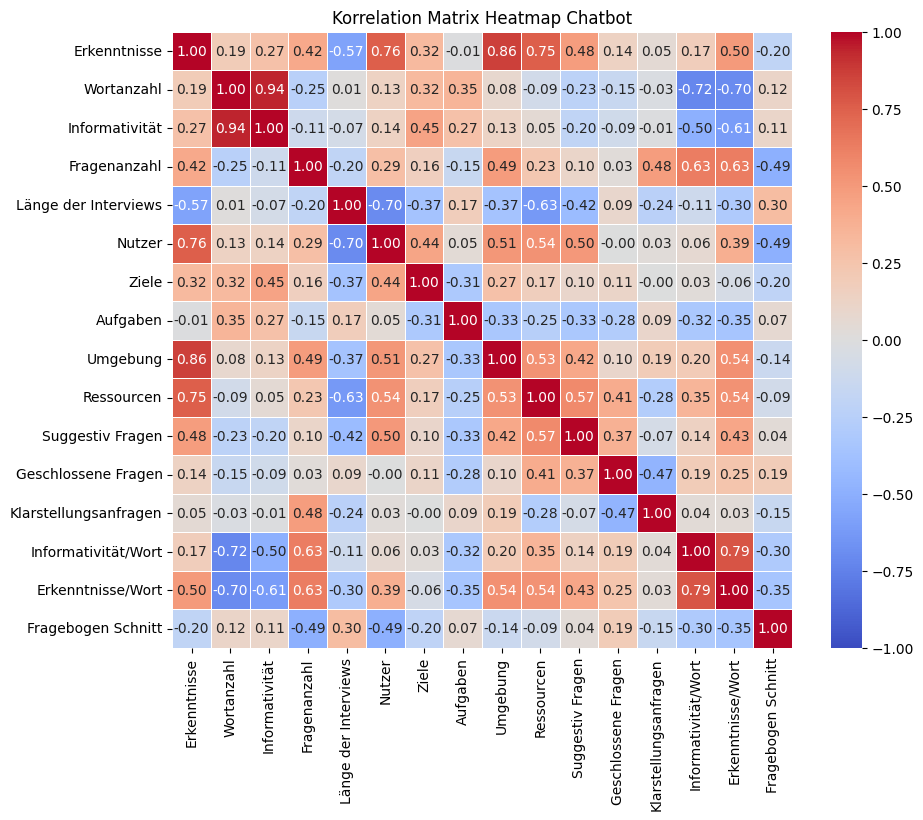

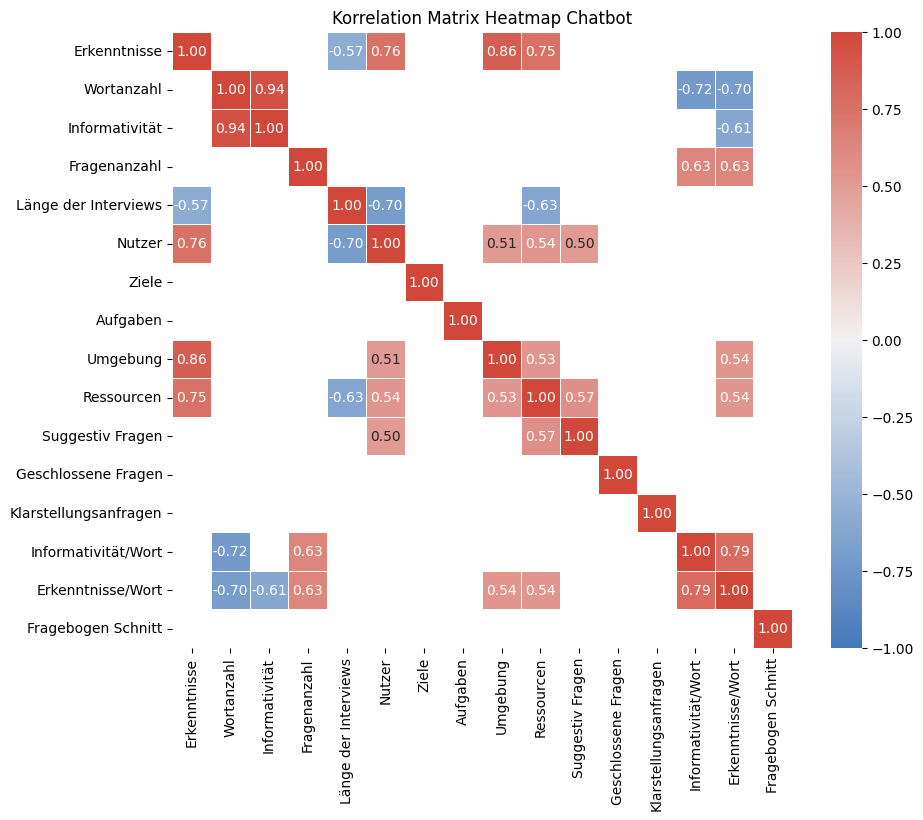

In [31]:
chatbot_metric_relevant_cols = extracted_chatbot_metric_df[columns_to_plot]
chatbot_metric_only_relevant_plot = chatbot_metric_relevant_cols.copy()

chatbot_metric_only_relevant_plot.columns = [
    "Erkenntnisse",
    "Wortanzahl",
    "Informativität",
    "Fragenanzahl",
    "Länge der Interviews",
    "Nutzer",
    "Ziele",
    "Aufgaben",
    "Umgebung",
    "Ressourcen",
    "Suggestiv Fragen",
    "Geschlossene Fragen",
    "Klarstellungsanfragen",
    "Informativität/Wort",
    "Erkenntnisse/Wort",
    "Fragebogen Schnitt",
]

correlation_matrix = chatbot_metric_only_relevant_plot.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Add title and display the plot
plt.title('Korrelation Matrix Heatmap Chatbot')
plt.show()

# Define a custom colormap 
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Create a mask for values between -0.5 and 0.5
mask = np.abs(correlation_matrix) < 0.5

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, mask = mask)

# Add title and display the plot
plt.title('Korrelation Matrix Heatmap Chatbot')
plt.show()


In [32]:
chatbot_metric_relevant_cols.corrwith(human_metric_only_relevant)

Erkenntnisse                       0.124587
Woerter_gesamt                     0.548005
informativität                     0.700539
fragen_gesamt                      0.173478
interview_laenge                  -0.190617
Nutzer                             0.544271
Ziele                              0.673633
Aufgaben                           0.411386
Umgebung                           0.027279
Ressourcen                         0.337418
leading_biased_fragen_pro_frage    0.176232
geschlossene_fragen_pro_frage     -0.063313
klarstellungsanfragen_pro_frage    0.039770
informativität_pro_wort            0.488849
Erkenntnisse_pro_wort              0.613832
fragebogen_schnitt                 0.184824
dtype: float64

#### T-wert, Standardabweichung, p-wert, Shapiro and cohen d


In [33]:
# https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests

# Sample Sizes
N = 16

# Degrees of freedom
dof = N - 1

# niveau of significance
nos = 0.05

columns_to_calculate = [
    "Erkenntnisse",
    "Woerter_gesamt",
    "informativität",
    "fragen_gesamt",
    "interview_laenge",
    "Nutzer",
    "Ziele",
    "Aufgaben",
    "Umgebung",
    "Ressourcen",
    "leading_biased_fragen_pro_frage",
    "geschlossene_fragen_pro_frage",
    "klarstellungsanfragen_pro_frage",
    "informativität_pro_wort",
    "Erkenntnisse_pro_wort",
    "fragebogen_schnitt",
]

results = pd.DataFrame()

for i, col in enumerate(columns_to_plot):
    x = extracted_human_metric_df[col]
    y = extracted_chatbot_metric_df[col]

    # mean
    chatbot_mean = np.mean(y)
    human_mean = np.mean(x)
    mean = np.mean((x + y) / 2)

    # Standard Deviation
    chatbot_std = np.std(y, ddof=1)  
    human_std = np.std(x, ddof=1)

    cohen_d = np.abs((chatbot_mean - human_mean) / np.std(x-y, ddof=1))

    t_stat, p_val = stats.ttest_rel(x, y, nan_policy="raise")

    results[col] = {
        "mean": mean,
        "chatbot_mean": chatbot_mean,
        "human_mean": human_mean,
        "chatbot_std": chatbot_std,
        "human_std": human_std,
        "cohen_d": cohen_d,
        "t_stat": t_stat,
        "p_val": p_val,
        "significant": p_val < nos,
    }

results

,Erkenntnisse,Woerter_gesamt,informativität,fragen_gesamt,interview_laenge,Nutzer,Ziele,Aufgaben,Umgebung,Ressourcen,leading_biased_fragen_pro_frage,geschlossene_fragen_pro_frage,klarstellungsanfragen_pro_frage,informativität_pro_wort,Erkenntnisse_pro_wort,fragebogen_schnitt
mean,21.21875,846.0,163.183905,25.46875,1102.6875,4.21875,1.59375,4.59375,6.03125,4.78125,0.134658,0.141131,0.019959,0.208482,0.038974,5.667969
chatbot_mean,17.25,358.625,78.163286,18.0625,1252.875,4.1875,1.5,4.3125,4.4375,2.8125,0.065926,0.103368,0.009762,0.225748,0.054589,4.722656
human_mean,25.1875,1333.375,248.204524,32.875,952.5,4.25,1.6875,4.875,7.625,6.75,0.203391,0.178894,0.030156,0.191215,0.023359,6.613281
chatbot_std,5.627314,126.925634,21.287535,8.842841,54.955588,0.834166,0.632456,1.851801,3.705289,2.166987,0.0703,0.036493,0.018465,0.03254,0.028035,1.373857
human_std,3.637192,573.688751,104.035505,3.612478,223.926178,1.064581,0.704154,1.454877,2.390955,1.390444,0.057552,0.05729,0.02721,0.027477,0.015216,0.484778
cohen_d,1.258244,1.892016,1.880818,1.654408,1.248806,0.067298,0.344729,0.308287,0.731985,1.836701,1.66356,1.081304,0.631984,1.126528,1.40539,1.380238
t_stat,5.032977,7.568063,7.52327,6.617634,-4.995226,0.269191,1.378916,1.233147,2.927941,7.346803,6.654241,4.325216,2.527937,-4.506112,-5.62156,5.520952
p_val,0.000149,0.000002,0.000002,0.000008,0.00016,0.79145,0.188137,0.236497,0.010389,0.000002,0.000008,0.000601,0.02319,0.000418,0.000049,0.000059
significant,True,True,True,True,True,False,False,False,True,True,True,True,True,True,True,True


In [34]:
from scipy.stats import shapiro as shapiro_test

# Function to calculate Shapiro-Wilk test for all metrics in a DataFrame
def calculate_shapiro_wilk(df, df_2):
    shapiro_results = {}
    for column in df.columns:
        stat, p_value = shapiro_test(df[column] - df_2[column])
        shapiro_results[column] = {'statistic': stat, 'p_value': p_value, 'significant': p_value < 0.05}
    return pd.DataFrame(shapiro_results).T

# Calculate Shapiro-Wilk test for metrics
shapiro_results = calculate_shapiro_wilk(extracted_human_metric_df, extracted_chatbot_metric_df)

shapiro_results

,statistic,p_value,significant
Erkenntnisse,0.925145,0.204021,False
Woerter_gesamt,0.938019,0.325456,False
informativität,0.919907,0.168103,False
fragen_gesamt,0.881537,0.041006,True
klarstellungsanfragen,0.884444,0.045536,True
leading_biased_fragen,0.937009,0.31398,False
geschlossene_fragen,0.946436,0.435418,False
interview_laenge,0.959195,0.647205,False
Nutzer,0.882006,0.041704,True
Ziele,0.718775,0.000274,True


In [35]:
# Function to create Q-Q plots for all metrics
def create_qq_plots(df, labels):
    fig, axes = plt.subplots(3, int(len(df.columns)/3), figsize=(10, 10))
    # Create Q-Q plots 
    for i, column in enumerate(df.columns):
        row = i // (int(len(df.columns)/3))
        col = i % (int(len(df.columns)/3))
        stats.probplot(df[column], dist="norm", plot=axes[row, col])
        axes[row, col].set_title(f' {labels[i]}')
        axes[row, col].set_xlabel('Theoretisches Quantil')
        axes[row, col].set_ylabel('Geordnete Werte')

    plt.tight_layout()
    plt.show()

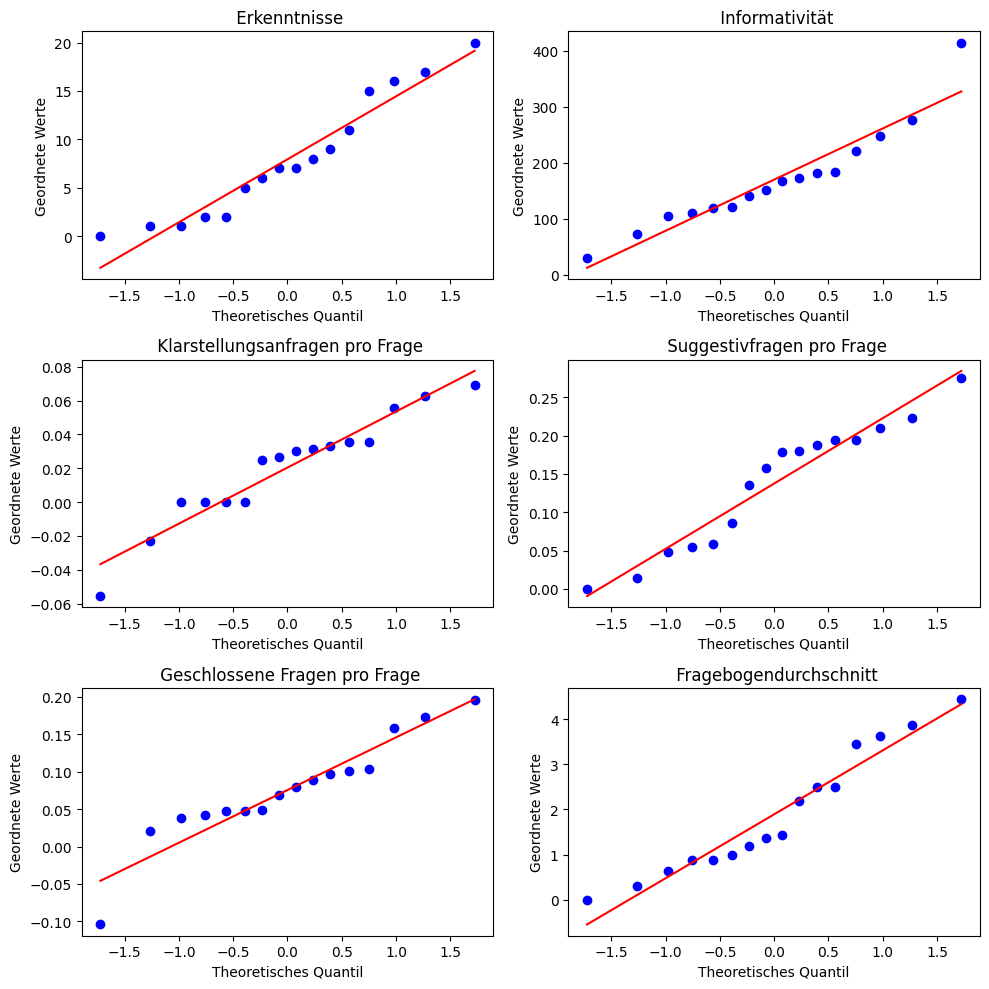

In [36]:
create_qq_plots(extracted_human_metric_df[['Erkenntnisse', 'informativität', "klarstellungsanfragen_pro_frage", "leading_biased_fragen_pro_frage", "geschlossene_fragen_pro_frage", "fragebogen_schnitt"]]-extracted_chatbot_metric_df[['Erkenntnisse', 'informativität', "klarstellungsanfragen_pro_frage", "leading_biased_fragen_pro_frage", "geschlossene_fragen_pro_frage", "fragebogen_schnitt"]],['Erkenntnisse', 'Informativität', "Klarstellungsanfragen pro Frage", "Suggestivfragen pro Frage", "Geschlossene Fragen pro Frage", "Fragebogendurchschnitt"])

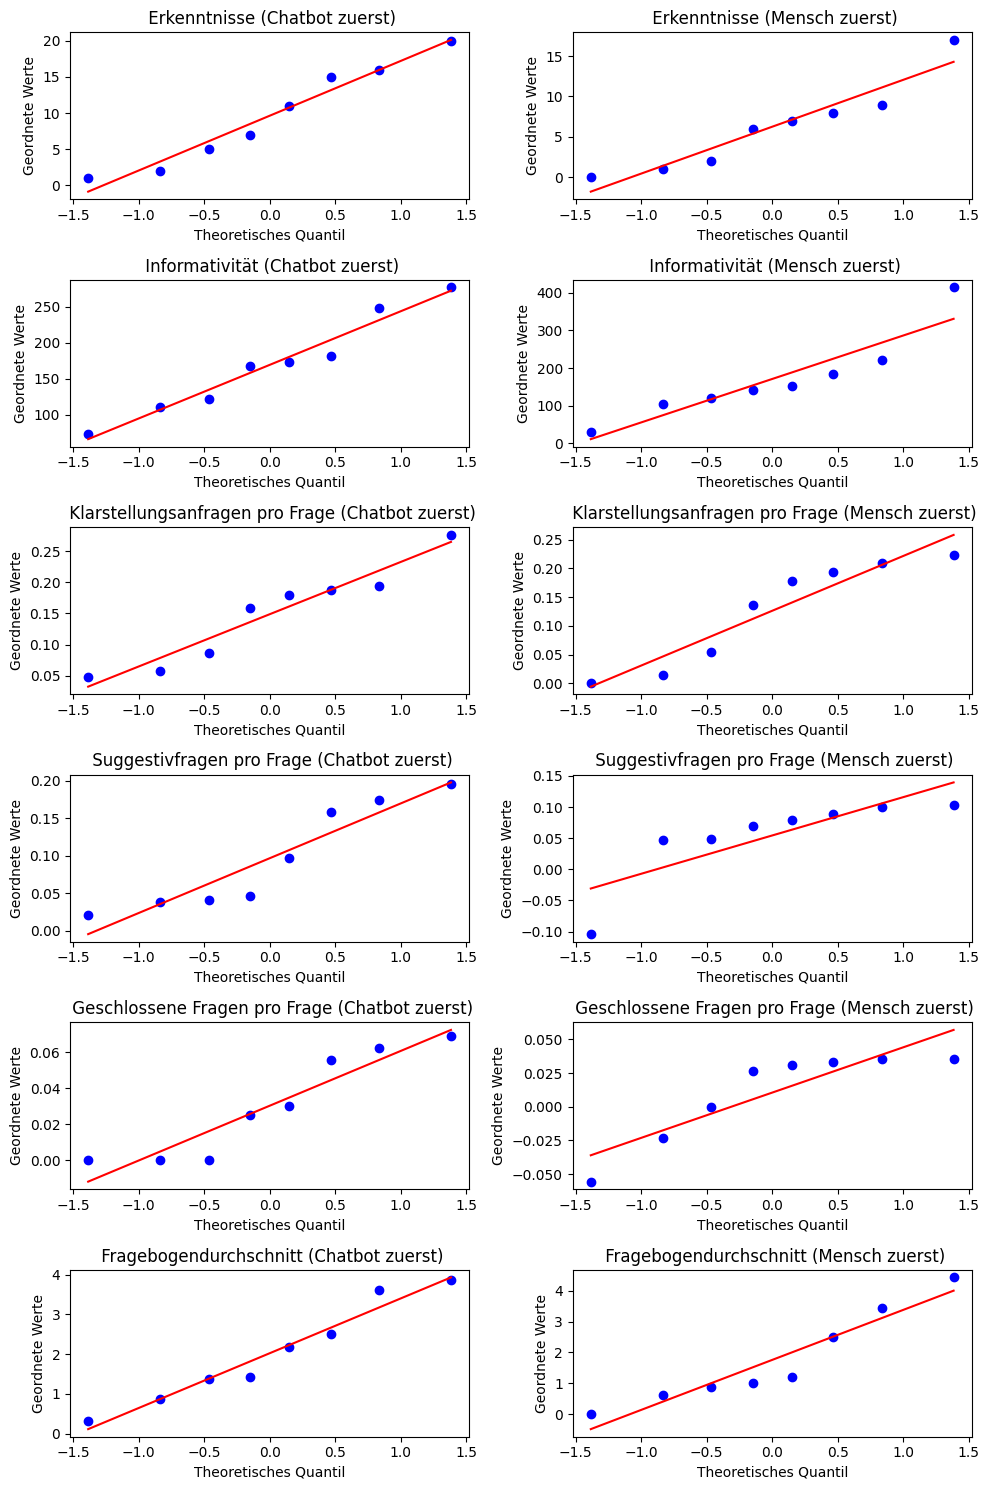

,Erkenntnisse,informativität,leading_biased_fragen_pro_frage,geschlossene_fragen_pro_frage,klarstellungsanfragen_pro_frage,fragebogen_schnitt
t_stat,1.075584,-0.038275,0.522744,1.231312,1.249373,0.376578
p_value,0.300301,0.970009,0.609326,0.23849,0.232014,0.712133
significant,False,False,False,False,False,False
shapiro_stat_human,0.916627,0.877341,0.871319,0.705698,0.789273,0.901814
shapiro_p_value_human,0.403097,0.177588,0.155266,0.002612,0.021951,0.29999
shapiro_significant_human,False,False,False,True,True,False
shapiro_stat_chatbot,0.94288,0.95805,0.927016,0.864158,0.859507,0.946799
shapiro_p_value_chatbot,0.639617,0.791334,0.489323,0.132051,0.118724,0.67894
shapiro_significant_chatbot,False,False,False,False,False,False


In [37]:
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import shapiro as shapiro_test

fig, axes = plt.subplots(6, 2, figsize=(10, 15))
labels = ['Erkenntnisse', 'Informativität', "Klarstellungsanfragen pro Frage", "Suggestivfragen pro Frage", "Geschlossene Fragen pro Frage", "Fragebogendurchschnitt"]

results = pd.DataFrame()
for i, col in enumerate([
    "Erkenntnisse",
    "informativität",
    "leading_biased_fragen_pro_frage",
    "geschlossene_fragen_pro_frage",
    "klarstellungsanfragen_pro_frage",
    "fragebogen_schnitt",
]):
    # Berechnung der Differenzwerte für jeden Teilnehmer
    differenz = extracted_human_metrics_with_group_df[col] - extracted_chatbot_metrics_with_group_df[col]
    chatbot_first = extracted_human_metrics_with_group_df["chatbot_first"]

    # Durchführen des unabhängigen t-Tests
    t_stat, p_value = ttest_ind(
        differenz[chatbot_first == True], 
        differenz[chatbot_first == False]
    )  

    # Shapiro-Wilk Test
    stat_chatbot, shapiro_p_value_chatbot = shapiro_test(differenz[chatbot_first == True])
    stat_f_human, shapiro_p_value_f_human = shapiro_test(differenz[chatbot_first == False])

    row = i 
    stats.probplot(differenz[chatbot_first == True], dist="norm", plot=axes[row, 0])
    axes[row, 0].set_title(f' {labels[i]} (Chatbot zuerst)')
    axes[row, 0].set_xlabel('Theoretisches Quantil')
    axes[row, 0].set_ylabel('Geordnete Werte')

    stats.probplot(differenz[chatbot_first == False], dist="norm", plot=axes[row, 1])
    axes[row, 1].set_title(f' {labels[i]} (Mensch zuerst)')
    axes[row, 1].set_xlabel('Theoretisches Quantil')
    axes[row, 1].set_ylabel('Geordnete Werte')

    results[col] = {
        't_stat': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'shapiro_stat_human': stat_f_human,
        'shapiro_p_value_human': shapiro_p_value_f_human,
        'shapiro_significant_human': shapiro_p_value_f_human < 0.05,
        'shapiro_stat_chatbot': stat_chatbot,
        'shapiro_p_value_chatbot': shapiro_p_value_chatbot,
        'shapiro_significant_chatbot': shapiro_p_value_chatbot < 0.05,
    }

plt.tight_layout()
plt.show()

results